In [1]:
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from padtools import helium_betas

In [2]:
exp = pd.read_excel('Data/exp_gauss3.xlsx', sheet_name='fitted').set_index('dataset')
exp = exp[[k for k in exp if k.startswith("he_") and k.endswith("_value")]]
exp = pd.concat(
    [
        exp,
        pd.read_excel('Data/Experimental intensity ratio and beta amplitude scale factor.xlsx', sheet_name='Best fit')
        .set_index('Dataset')['Amp scale factor'],
    ],
    axis=1,
)
exp['Photon (eV)'] = pd.Series({'good1': 15.9, 'good2': 14.3, 'good3': 19.1, 'good4': 15.9})
exp

,he_beta1_amp_value,he_beta1_freq_value,he_beta1_offset_value,he_beta1_shift_value,he_beta1m3_amp_value,he_beta1m3_freq_value,he_beta1m3_offset_value,he_beta1m3_shift_value,he_beta2_c_value,he_beta3_amp_value,he_beta3_freq_value,he_beta3_offset_value,he_beta3_shift_value,he_beta4_c_value,Amp scale factor,Photon (eV)
good1,0.534221,6.283185,-0.011979,0.236018,0.113821,6.283185,0.025286,1.751174,1.630931,0.809978,6.283185,-0.055897,0.023973,1.028259,0.360079,15.9
good2,0.347818,6.283185,-0.072793,0.075804,0.141339,6.283185,-0.033517,1.701427,0.855773,0.573820,6.283185,-0.058915,-0.302036,0.935211,0.262322,14.3
good3,0.496982,6.283185,-0.040736,5.368111,0.029859,6.283185,0.012651,4.345623,1.783591,0.723138,6.283185,-0.080080,5.420992,1.010375,0.316547,19.1
good4,0.281430,6.283185,-0.088810,4.612789,0.056858,6.283185,-0.034449,6.282104,1.691176,0.438820,6.283185,-0.081541,4.418148,0.411959,0.226153,15.9


In [3]:
the = pd.read_excel('Data/Simulated He beta parameters, TDSE.xlsx').set_index('Photon (eV)')
the

,Int_w (W/cm2),Int_2w (W/cm2),Int ratio,Ref int ratio,coeff_s,coeff_p,coeff_d,eta_s,eta_p,eta_d
Photon (eV),,,,,,,,,,
14.3,10000000000000,13600000000,1.166190e-08,1.166190e-08,0.003220,0.01140,-0.01090,5.36,2.26,0
15.0,10000000000000,13400000000,1.157584e-08,1.157584e-08,0.002530,0.01050,-0.01020,5.22,2.19,0
15.9,10000000000000,12500000000,1.118034e-08,1.118034e-08,0.001770,0.00944,-0.00928,5.07,2.12,0
16.0,10000000000000,12600000000,1.122497e-08,1.122497e-08,0.001690,0.00933,-0.00917,5.06,2.11,0
17.0,10000000000000,11800000000,1.086278e-08,1.086278e-08,0.000986,0.00830,-0.00824,4.94,2.06,0
18.0,10000000000000,11300000000,1.063015e-08,1.063015e-08,0.000339,0.00746,-0.00745,4.84,2.01,0
19.0,10000000000000,11100000000,1.053565e-08,1.053565e-08,-0.000392,0.00685,-0.00684,4.77,1.98,0
19.1,10000000000000,11000000000,1.048809e-08,1.048809e-08,-0.000601,0.00676,-0.00673,4.76,1.98,0
19.5,10000000000000,11400000000,1.067708e-08,1.067708e-08,-0.001020,0.00669,-0.00661,4.73,1.97,0


In [4]:
def b_to_beta(b0, b1_amp, b1_shift, b2, b3_amp, b3_shift, b4, b1m3_amp, b1m3_shift):
    return {
        'beta1_amp': b1_amp / b0,
        'beta1_shift': b1_shift,
        'beta2': b2 / b0,
        'beta3_amp': b3_amp / b0,
        'beta3_shift': b3_shift,
        'beta4': b4 / b0,
        'beta1m3_amp': b1m3_amp / b0,
        'beta1m3_shift': b1m3_shift,
    }


def rescale(d, r):
    relr = r / d['Int ratio'] * d['Ref int ratio']
    ret = helium_betas(**{
        **{k: v for k, v in d.items() if k.startswith('coeff_') or k.startswith('eta_')},
        'coeff_p': d['coeff_p'] * relr,
    })
    return b_to_beta(**ret)


r = np.linspace(0, 20, 2001)[1:]
rescaled = {
    k: pd.DataFrame({'Rel int ratio': r, **rescale(d, r)}).set_index('Rel int ratio')
    for k, d in the.iterrows()
}

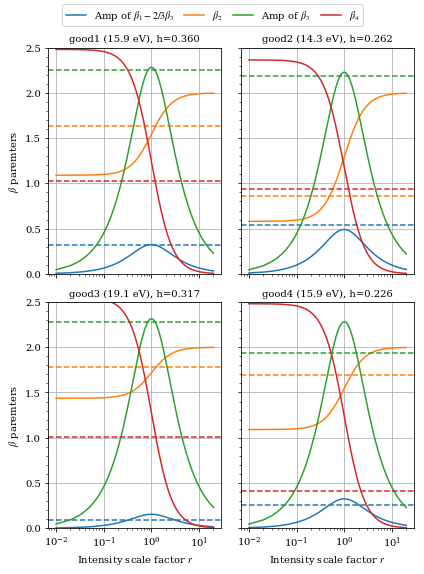

In [5]:
plt.style.use("Report.mplstyle")
plt.figure(figsize=(6, 8))
for i, dataset in enumerate(exp.index):
    ph = exp.loc[dataset, 'Photon (eV)']
    hh = exp.loc[dataset, 'Amp scale factor']
    plt.subplot(2, 2, i+1)
    plt.title(f"{dataset} ({ph} eV), h={hh:.3f}")
    plt.xlabel(r'Intensity scale factor $r$')
    plt.ylabel(r'$\beta$ paremters')
    for h, k, l, prop in zip(
            ['he_beta1m3_amp_value', 'he_beta2_c_value', 'he_beta3_amp_value', 'he_beta4_c_value'],
            ['beta1m3_amp', 'beta2', 'beta3_amp', 'beta4'],
            [r'Amp of $\beta_1 - 2/3 \beta_3$', r'$\beta_2$', r'Amp of $\beta_3$', r'$\beta_4$'],
            plt.rcParams['axes.prop_cycle'],
        ):
        sign, factor = 1, 1
        if k.endswith('_amp'):
            if all(v < 0 for v in rescaled[ph][k]):
                sign = -1
            factor = hh
        plt.axhline(exp.loc[dataset, h] / factor, linestyle='dashed', **prop)
        plt.plot(sign * rescaled[ph][k], label=l, **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(0, 2.5)
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)
    plt.gca().label_outer()
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

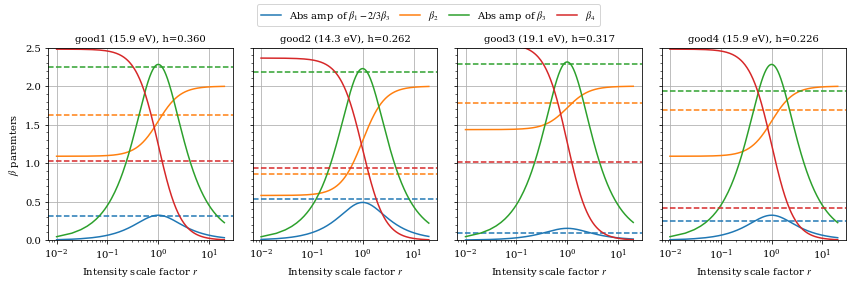

In [6]:
plt.style.use("Report.mplstyle")
plt.figure(figsize=(12, 4))
for i, dataset in enumerate(exp.index):
    ph = exp.loc[dataset, 'Photon (eV)']
    hh = exp.loc[dataset, 'Amp scale factor']
    plt.subplot(1, 4, i+1)
    plt.title(f"{dataset} ({ph} eV), h={hh:.3f}")
    plt.xlabel(r'Intensity scale factor $r$')
    plt.ylabel(r'$\beta$ paremters')
    for h, k, l, prop in zip(
            ['he_beta1m3_amp_value', 'he_beta2_c_value', 'he_beta3_amp_value', 'he_beta4_c_value'],
            ['beta1m3_amp', 'beta2', 'beta3_amp', 'beta4'],
            [r'Abs amp of $\beta_1 - 2/3 \beta_3$', r'$\beta_2$', r'Abs amp of $\beta_3$', r'$\beta_4$'],
            plt.rcParams['axes.prop_cycle'],
        ):
        sign, factor = 1, 1
        if k.endswith('_amp'):
            if all(v < 0 for v in rescaled[ph][k]):
                sign = -1
            factor = hh
        plt.axhline(exp.loc[dataset, h] / factor, linestyle='dashed', **prop)
        plt.plot(sign * rescaled[ph][k], label=l, **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(0, 2.5)
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)
    plt.gca().label_outer()
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.savefig('Figures/Intensity dependence of beta parameters, He.pdf')
plt.show()